# Oliver

In [2]:
import csv
import pandas as pd
import urllib.request
import pickle
import re
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities
from collections import Counter


In [29]:
# 1) Load full LABMT with all original columns ----
labmt_df = pd.read_csv(
    "Data_Set_S1.txt",
    sep="\t",
    skiprows=2,   # remove only the two description lines
    encoding="utf-8"
)

print("DataFrame loaded:", labmt_df.shape)
display(labmt_df.head())

# 2) Build dictionary: word + happiness score ----
labmt = {
    row["word"].lower(): float(row["happiness_average"])
    for _, row in labmt_df.iterrows()
}

print("Dictionary size:", len(labmt))
list(labmt.items())[:5]


DataFrame loaded: (10222, 8)


word  happiness_rank  happiness_average  happiness_standard_deviation  \
0   laughter               1               8.50                        0.9313   
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

  twitter_rank google_rank nyt_rank lyrics_rank  
0         3600          --       --        1728  
1         1853        2458       --        1230  
2           25         317      328          23  
3           65        1372     1313         375  
4         3334        3542       --        2332

Dictionary size: 10222


[('laughter', 8.5),
 ('happiness', 8.44),
 ('love', 8.42),
 ('happy', 8.3),
 ('laughed', 8.26)]

In [30]:
hp1_tokens = pickle.load(open("Harry_potter_tokens/hp1_tokens.pkl", "rb"))
hp2_tokens = pickle.load(open("Harry_potter_tokens/hp2_tokens.pkl", "rb"))
hp3_tokens = pickle.load(open("Harry_potter_tokens/hp3_tokens.pkl", "rb"))
hp4_tokens = pickle.load(open("Harry_potter_tokens/hp4_tokens.pkl", "rb"))
hp5_tokens = pickle.load(open("Harry_potter_tokens/hp5_tokens.pkl", "rb"))
hp6_tokens = pickle.load(open("Harry_potter_tokens/hp6_tokens.pkl", "rb"))
hp7_tokens = pickle.load(open("Harry_potter_tokens/hp7_tokens.pkl", "rb"))

In [31]:
hp_tokens = {
    "HP1": hp1_tokens,
    "HP2": hp2_tokens,
    "HP3": hp3_tokens,
    "HP4": hp4_tokens,
    "HP5": hp5_tokens,
    "HP6": hp6_tokens,
    "HP7": hp7_tokens,
}

print("Chapters per book: ", {k: len(v) for k, v in hp_tokens.items()})


Chapters per book:  {'HP1': 17, 'HP2': 18, 'HP3': 22, 'HP4': 37, 'HP5': 38, 'HP6': 30, 'HP7': 36}


In [32]:
def sentiment_from_tokens(tokens, labmt_dict, neutral_low=4.0, neutral_high=6.0):
    scores = []
    for t in tokens:
        s = labmt_dict.get(t.lower())
        if s is None:
            continue
        if neutral_low <= s <= neutral_high:
            continue
        scores.append(s)
    return float(np.mean(scores)) if scores else math.nan


In [36]:
chapter_sent = {}

for book_id, chapters in hp_tokens.items():
    chapter_sent[book_id] = {}
    for chap_num in sorted(chapters.keys()):
        tokens = chapters[chap_num]
        chapter_sent[book_id][chap_num] = sentiment_from_tokens(tokens, labmt)

# example: sentiments for HP1
chapter_sent["HP5"]


{1: 5.697289211242068,
 2: 5.726904176904177,
 3: 5.762072263549415,
 4: 5.705820463320463,
 5: 5.687525354969574,
 6: 5.782854926299457,
 7: 5.822292609351433,
 8: 5.778462643678161,
 9: 5.7615161957270855,
 10: 5.843023493360572,
 11: 5.92859649122807,
 12: 5.769282147315855,
 13: 5.725502336448599,
 14: 5.824101694915254,
 15: 5.861073684210526,
 16: 5.895904590459046,
 17: 5.792462562396007,
 18: 5.804193817878028,
 19: 5.802197986577181,
 20: 5.777900797165633,
 21: 5.756465517241379,
 22: 5.689873772791024,
 23: 5.911430481283422,
 24: 5.713678398895791,
 25: 5.7289054054054045,
 26: 5.723486120077469,
 27: 5.698113342898135,
 28: 5.846166547020818,
 29: 5.853285714285715,
 30: 5.7577655172413795,
 31: 5.780332103321033,
 32: 5.533090277777778,
 33: 5.653676268861454,
 34: 5.642173333333333,
 35: 5.306452648475121,
 36: 5.301368876080691,
 37: 5.607294460641399,
 38: 5.750056100981767}

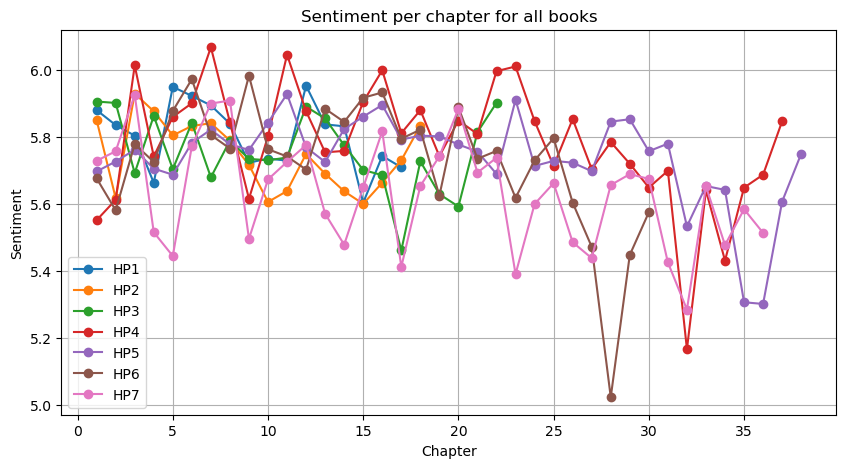

In [38]:
def plot_all_books_sentiment(chapter_sent_dict):
    plt.figure(figsize=(10, 5))
    for book_id, ch_dict in chapter_sent_dict.items():
        chaps = sorted(ch_dict.keys())
        vals = [ch_dict[c] for c in chaps]
        vals = [v if not np.isnan(v) else None for v in vals]
        plt.plot(chaps, vals, marker="o", label=book_id)

    plt.xlabel("Chapter")
    plt.ylabel("Sentiment")
    plt.title("Sentiment per chapter for all books")
    plt.legend()
    plt.grid(True)
    plt.show()

# example:
plot_all_books_sentiment(chapter_sent)


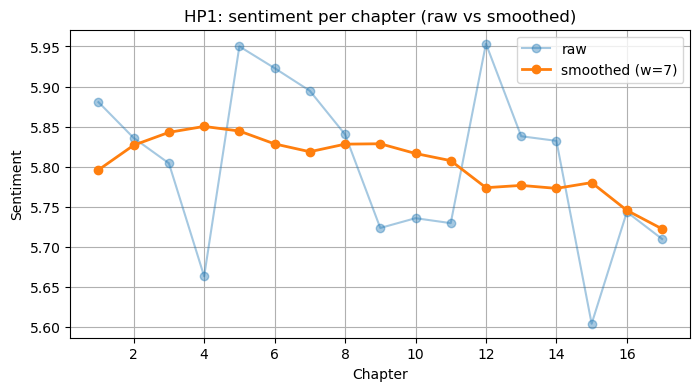

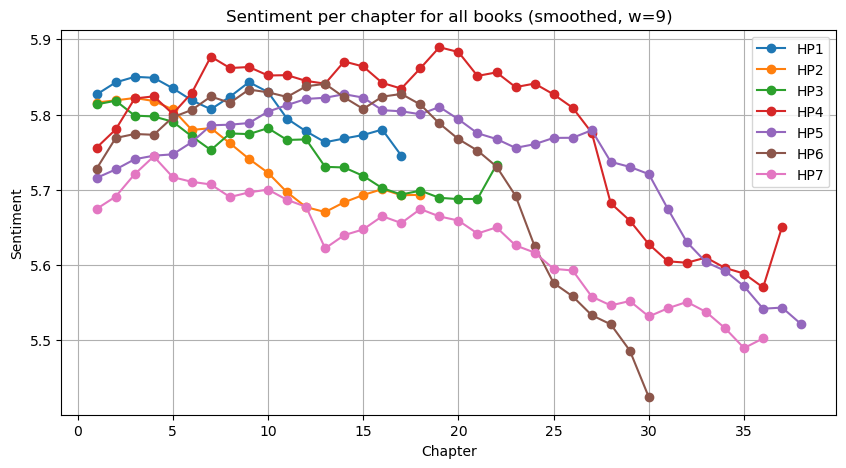

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Helper: moving-average smoothing (ignoring NaNs)
def smooth_series(values, window=3):
    """
    Simple centered moving average.
    window should be an odd integer (3,5,7,...).
    """
    arr = np.array(values, dtype=float)
    smoothed = []

    for i in range(len(arr)):
        start = max(0, i - window // 2)
        end = min(len(arr), i + window // 2 + 1)
        window_vals = arr[start:end]
        window_vals = window_vals[~np.isnan(window_vals)]
        smoothed.append(np.nan if len(window_vals) == 0 else np.mean(window_vals))

    return smoothed


# 2) Plot sentiment per chapter for a single book (raw + smoothed)
def plot_book_sentiment_smoothed(book_id, chapter_sent_dict, window=3):
    chaps = sorted(chapter_sent_dict[book_id].keys())
    raw_vals = [chapter_sent_dict[book_id][c] for c in chaps]
    raw_vals = [v if not np.isnan(v) else None for v in raw_vals]

    smooth_vals = smooth_series(raw_vals, window=window)

    plt.figure(figsize=(8, 4))
    plt.plot(chaps, raw_vals, marker="o", alpha=0.4, label="raw")
    plt.plot(chaps, smooth_vals, marker="o", linewidth=2, label=f"smoothed (w={window})")
    plt.xlabel("Chapter")
    plt.ylabel("Sentiment")
    plt.title(f"{book_id}: sentiment per chapter (raw vs smoothed)")
    plt.grid(True)
    plt.legend()
    plt.show()


# 3) Plot all books on the same graph (smoothed only)
def plot_all_books_sentiment_smoothed(chapter_sent_dict, window=3):
    plt.figure(figsize=(10, 5))
    for book_id, ch_dict in chapter_sent_dict.items():
        chaps = sorted(ch_dict.keys())
        vals = [ch_dict[c] for c in chaps]
        vals = [v if not np.isnan(v) else None for v in vals]
        smooth_vals = smooth_series(vals, window=window)
        plt.plot(chaps, smooth_vals, marker="o", label=book_id)

    plt.xlabel("Chapter")
    plt.ylabel("Sentiment")
    plt.title(f"Sentiment per chapter for all books (smoothed, w={window})")
    plt.grid(True)
    plt.legend()
    plt.show()


# 4) Examples (assuming chapter_sent is already computed)
#window=3  : light smoothing
#window=5  : medium smoothing
#window=7  : strong smoothing
#window=9  : very smooth
#window=11 : almost a rolling trendline
plot_book_sentiment_smoothed("HP1", chapter_sent, window=7) 
plot_all_books_sentiment_smoothed(chapter_sent, window=9)


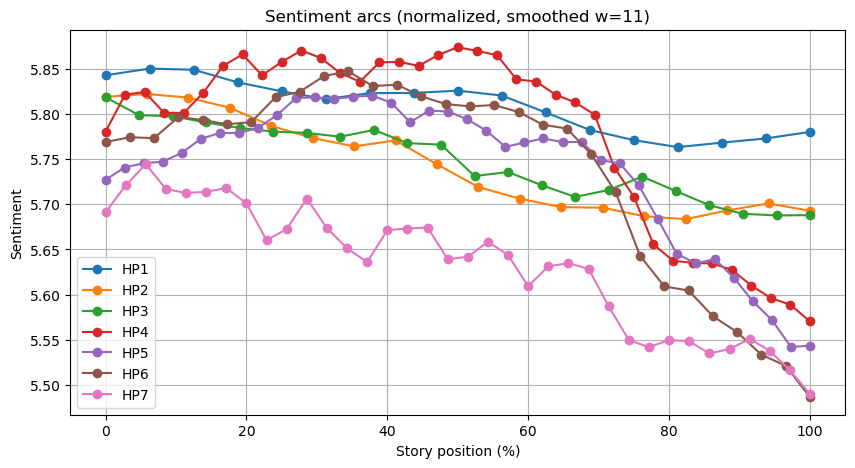

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_books_sentiment_normalized(chapter_sent_dict, window=5):
    plt.figure(figsize=(10, 5))

    for book_id, ch_dict in chapter_sent_dict.items():
        chaps = sorted(ch_dict.keys())
        vals = [ch_dict[c] for c in chaps]
        vals = [v if not np.isnan(v) else None for v in vals]

        smooth_vals = smooth_series(vals, window=window)

        # Normalize chapter index to [0, 100]
        if len(chaps) == 1:
            xs = [100.0]
        else:
            xs = np.linspace(0, 100, num=len(chaps))

        plt.plot(xs, smooth_vals, marker="o", label=book_id)

    plt.xlabel("Story position (%)")
    plt.ylabel("Sentiment")
    plt.title(f"Sentiment arcs (normalized, smoothed w={window})")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example:
plot_all_books_sentiment_normalized(chapter_sent, window=11)


In [ ]:
book_sent = {}

for book_id, chapters in hp_tokens.items():
    all_tokens = [tok for chap_tokens in chapters.values() for tok in chap_tokens]
    book_sent[book_id] = sentiment_from_tokens(all_tokens, labmt)

book_sent

{'HP1': 5.807663956278326,
 'HP2': 5.744944578927251,
 'HP3': 5.763377936515921,
 'HP4': 5.792637327430534,
 'HP5': 5.742691620966714,
 'HP6': 5.742388442306476,
 'HP7': 5.629984620365874}

In [44]:
# git


























# Lucas

## Preliminary Data Analyses

Concepts:
* **Nodes, Edges, Density, Clustering** 
* **Degree Distributions**
* **Degree Centralities**
* **Check Neighbours**
* **Assortativity**
* **Backbone Analysis**
* **Connected Components**

In [1]:
import urllib.request
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

# Load the directed graph
G = nx.read_gexf("harry_potter_characters_network.gexf")

In [5]:
# What is the number of nodes in the network ?
print(f'Number of nodes: {len(G.nodes)}')
# What is the number of links ?
print(f'Number of edges: {len(G.edges)}')
# What attributes are present in the network ?
print(f'Node attributes: {list(G.nodes(data=True))[0][1].keys()}')

Number of nodes: 133
Number of edges: 5175
Node attributes: dict_keys(['Gender', 'House', 'Blood status', 'Boggart', 'Species', 'label'])


In [6]:
# What is the density ?
density = nx.density(G.to_undirected())
print(f'Network density: {density}')
# What is the average clustering coefficient ?
clustering_coeff = nx.average_clustering(G.to_undirected())
print(f'Average clustering coefficient: {clustering_coeff}')

Network density: 0.33356117566643884
Average clustering coefficient: 0.7304225118665753


From the above we get some preliminary data on the graph:
* **Number of Nodes**: 133
* **Number of Edges**: 5175
* **Density**: 0.33
* **Average clustering Coefficient**: 0.73
* **Attributes**: Gender, House, Blood status, Boggart, Species

With just 133 nodes and 5175 eddges, the graph is quite dense. From this we would expect almost every chracter should be reachable from every other in relative few steps, meaning the average shortest path length should be short.

Further with a relative high density the graph reflects a network where " everyone knows everyone" rather than being a sparse network. The average clustering coefficient is also relatively high indicating there are strong "friend" groups present. It will be interesting to see what kind of cliques are revealed in later analyses. 

## Random vs. scale free (Boring Don't use)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [2]:
# Load graph 
G = nx.read_gexf("harry_potter_characters_network.gexf")

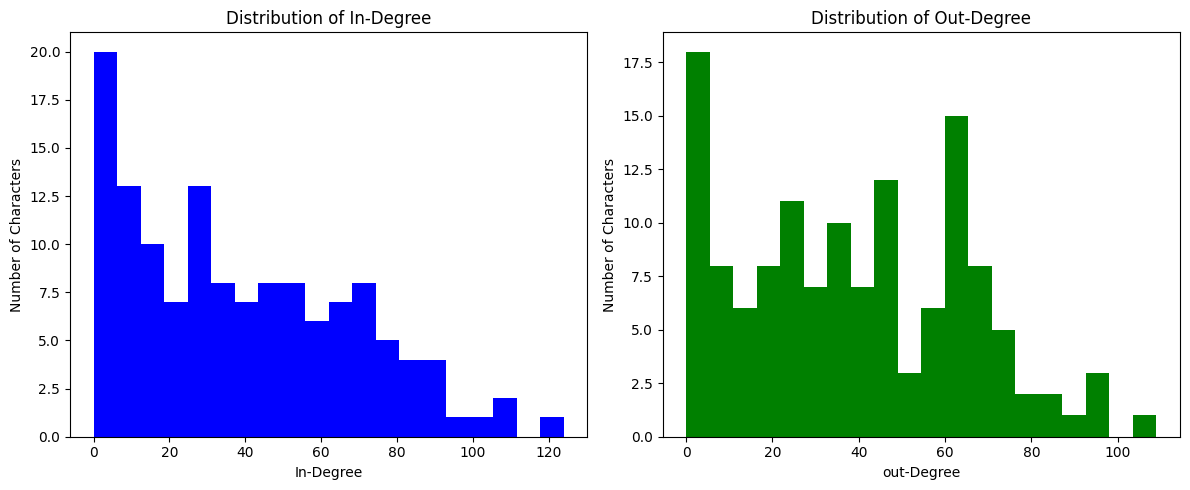

In [ ]:
# Plotting the in degree distribution and out degree distribution side by side
in_degrees  = [G.in_degree(n) for n in G.nodes()]
out_degrees = [G.out_degree(n) for n in G.nodes()]

plt.figure(figsize=(12, 5))

# Plot in-degree distribution
plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=20, color='blue')
plt.xlabel('In-Degree')
plt.ylabel('Number of Characters')
plt.title('Distribution of In-Degree')

# Plot out-degree distribution
plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=20, color='green')
plt.xlabel('out-Degree')
plt.ylabel('Number of Characters')
plt.title('Distribution of Out-Degree')
plt.tight_layout()
plt.show()

## Centralities and Assortativity

In [1]:
import networkx as nx
import pandas as pd

In [2]:
# Load the directed graph
G = nx.read_gexf("harry_potter_characters_network.gexf")

In [3]:
# Find 5 most according to degree centality 
degree_centrality = nx.degree_centrality(G)
#degree_centrality = nx.degree_centrality(G.to_undirected())
df_degree = pd.DataFrame(list(degree_centrality.items()), columns=["Character", "degree centrality"])
df_degree = df_degree.sort_values(by="degree centrality", ascending=False)
df_degree.reset_index(drop=True, inplace=True)
print(df_degree.head(10))

            Character  degree centrality
0        Harry Potter           1.765152
1    Hermione Granger           1.583333
2      Ronald Weasley           1.522727
3    Albus Dumbledore           1.446970
4  Neville Longbottom           1.333333
5  Minerva McGonagall           1.325758
6     Ginevra Weasley           1.287879
7       Rubeus Hagrid           1.265152
8       Severus Snape           1.242424
9          Tom Riddle           1.242424


As one might expect the most central character according to just number of links is Harry Potter, Hermione and Ronald Weasly. This lines up with the story as well as these are the main chracters we follow.

Perhaps the most interesting placements are Neville Longbottom being so high and Tom Riddle being so low since he is the antagonist in the story.
But we do follow the story primarily from the "good guys" perspective throughout the story, so generally we have more information and interactions on this side in general. Neville also appears as an important figure throughout the stories. He helps Harry win the Goblet of Fire and cuts the head of the Nagini one of Voldemorts horcruxes. 

In [4]:
# Find 5 most central according to betweenness centrality - how often a node lies on the shortest path between other nodes
betweenness_centrality = nx.betweenness_centrality(G)
#degree_centrality = nx.degree_centrality(G.to_undirected())
df_degree = pd.DataFrame(list(betweenness_centrality.items()), columns=["Character", "betweenness centrality"])
df_degree = df_degree.sort_values(by="betweenness centrality", ascending=False)
df_degree.reset_index(drop=True, inplace=True)
print(df_degree.head(10))

            Character  betweenness centrality
0        Harry Potter                0.104651
1    Hermione Granger                0.060161
2      Ronald Weasley                0.037118
3       Rubeus Hagrid                0.032058
4    Albus Dumbledore                0.026140
5  Minerva McGonagall                0.019475
6    Dolores Umbridge                0.017931
7  Neville Longbottom                0.017268
8     Ginevra Weasley                0.016475
9          Tom Riddle                0.016181


What interesting is Hagrid lies higher on the betweenees centrality. This can be seen as reflecting his role as essentially "the janitor" of Hogwarts school and he has been there for multiple generations. And the chracter list also contains magical creatues. Here Hagrid is most likely to be bound to these making and between link the creatues and the rest of the characters.

Another interesting appearances Dolores Umbridge. This is also reflected in the story since she essentially works in the ministry, becomes headmaster of Hogwarts eventually for a period and ends up collaborating the death eaters and voldemort later in the story.

In [5]:
# Looking at eigen centrality - Nodes connected to high scoring nodes contribute more to the score of the node than equal connections to low scoring nodes
eigen_centrality = nx.eigenvector_centrality(G)
#degree_centrality = nx.degree_centrality(G.to_undirected())
df_degree = pd.DataFrame(list(eigen_centrality.items()), columns=["Character", "eigenvector centrality"])
df_degree = df_degree.sort_values(by="eigenvector centrality", ascending=False)
df_degree.reset_index(drop=True, inplace=True)
print(df_degree.head(10))

            Character  eigenvector centrality
0        Harry Potter                0.162343
1      Ronald Weasley                0.158121
2    Hermione Granger                0.157341
3          Tom Riddle                0.156731
4    Albus Dumbledore                0.153621
5       Severus Snape                0.149050
6  Minerva McGonagall                0.148918
7  Neville Longbottom                0.147005
8     Ginevra Weasley                0.144039
9         Remus Lupin                0.141958


With Eigen centrality we now see Tom riddle rising higher on the list. This makes sense he might have a lower degree compared to the good guys, he is the antagonist of the story and is of course connected to Harry, Dumbledore who was his teacher and later becomes an opponent. He also has as story with Hagrid who was on the top 10 of degree cenrality. 

Interestingly Hermione and Ron switch places here, why ? Well while Hermione might be connected to more characters, Ron is connected to his entire Weasly family which plays central roles throughout the stories, and they are also connected to the main characters such as Harry.

In [6]:
degree_assortativity = nx.degree_assortativity_coefficient(G.to_undirected())
house = nx.attribute_assortativity_coefficient(G.to_undirected(), "House")
gender = nx.attribute_assortativity_coefficient(G.to_undirected(), "Gender")
species =nx.attribute_assortativity_coefficient(G.to_undirected(), "Species")
blood_status = nx.attribute_assortativity_coefficient(G.to_undirected(), "Blood status")

print("Degree assortativity coefficient:", degree_assortativity)
print("House assortativity coefficient:", house)
print("Gender assortativity coefficient:", gender)
print("Species assortativity coefficient:", species)
print("Blood status assortativity coefficient:", blood_status)

Degree assortativity coefficient: -0.23611704371998252
House assortativity coefficient: -0.006036624526472954
Gender assortativity coefficient: -0.0007259393966274979
Species assortativity coefficient: 0.01611300281855359
Blood status assortativity coefficient: -0.004253180451219253


The degree assortatvity indicates that high degree nodes connect to low degree nodes indicating star like structures with hierachies. We would expect to see these being formed around chracters such as Harry Potter, Tom riddle and Dumbledore.

The assortativity based on House, Gender, Species, Blood status are all relatively close to zero, indicating links are formed randomly at least with respect to these attributes. This makes sense to Gender, Species perhaps. But surprinsingly connections are not formed with respect to houses or blood status. Which is interesting since the underlying motivation of conflict in the story is the blood sttaus and pure bloods wanting to create a pure magical world.

In [7]:
# Investigating clustering and coefficient of different houses by only keeping nodes with attribute of a speicfic house and their immediate edges
houses = ["Gryffindor", "Slytherin", "Hufflepuff", "Ravenclaw"]
for house in houses:
    house_nodes = [n for n, attr in G.nodes(data=True) if attr.get("House") == house]
    subgraph = G.subgraph(house_nodes)
    clustering_coeff = nx.average_clustering(subgraph.to_undirected())
    # print number of nodes and edges in the subgraph
    print(f'Number of nodes in {house}: {subgraph.number_of_nodes()}')
    print(f'Number of edges in {house}: {subgraph.number_of_edges()}')
    # print the characters in the house
    print(f'Characters in {house}: {[n for n in subgraph.nodes()]}')

    print(f'Average clustering coefficient for {house}: {clustering_coeff}')

Number of nodes in Gryffindor: 31
Number of edges in Gryffindor: 587
Characters in Gryffindor: ['Arthur Weasley', 'Rubeus Hagrid', 'Lily Potter (I)', 'James Potter (I)', 'Lavender Brown', 'Ronald Weasley', 'Cadogan', 'Charles Weasley', 'Ginevra Weasley', 'Godric Gryffindor', 'Minerva McGonagall', 'Sir Nicholas de Mimsy-Porpington', 'Neville Longbottom', 'Molly Weasley', 'Fat Lady', 'Sirius Black', 'Parvati Patil', 'Colin Creevey', 'George Weasley', 'William Weasley', 'Hermione Granger', 'Albus Dumbledore', 'Percy Weasley', 'Seamus Finnigan', 'Harry Potter', 'Euan Abercrombie', 'Remus Lupin', 'Dennis Creevey', 'Fred Weasley', 'Peter Pettigrew', 'Dean Thomas']
Average clustering coefficient for Gryffindor: 0.8069993601374669
Number of nodes in Slytherin: 15
Number of edges in Slytherin: 125
Characters in Slytherin: ['Lucius Malfoy', 'Avery (Riddle-era)', 'Bloody Baron', 'Bellatrix Lestrange', 'Regulus Black', 'Severus Snape', 'Gregory Goyle', 'Horace Slughorn', 'Draco Malfoy', 'Tom Riddl

In [9]:
# Investigating clustering and coefficient of different houses by only keeping nodes with attribute of a speicfic house and their immediate edges
blood_statuses = ["Pure-blood", "Half-blood", "Muggle-born"]
for blood_status in blood_statuses:
    blood_status_nodes = [n for n, attr in G.nodes(data=True) if attr.get("Blood status") == blood_status]
    subgraph = G.subgraph(blood_status_nodes)
    clustering_coeff = nx.average_clustering(subgraph.to_undirected())
    # print number of nodes and edges in the subgraph
    print(f'Number of nodes in {blood_status}: {subgraph.number_of_nodes()}')
    print(f'Number of edges in {blood_status}: {subgraph.number_of_edges()}')
    # print the characters in the house
    print(f'Characters in {blood_status}: {[n for n in subgraph.nodes()]}')

    print(f'Average clustering coefficient for {blood_status}: {clustering_coeff}')

Number of nodes in Pure-blood: 26
Number of edges in Pure-blood: 399
Characters in Pure-blood: ['Lucius Malfoy', 'Arthur Weasley', 'Viktor Krum', 'James Potter (I)', 'Lavender Brown', 'Ronald Weasley', 'Charles Weasley', 'Ginevra Weasley', 'Neville Longbottom', 'Molly Weasley', 'Poliakoff', 'Sirius Black', 'Alastor Moody', 'Draco Malfoy', 'George Weasley', 'William Weasley', 'Salazar Slytherin', 'Percy Weasley', 'Kingsley Shacklebolt', 'Regulus Black', 'Vincent Crabbe', 'Narcissa Malfoy', 'Bartemius Crouch Senior', 'Bellatrix Lestrange', 'Gregory Goyle', 'Fred Weasley']
Average clustering coefficient for Pure-blood: 0.7925052591757658
Number of nodes in Half-blood: 18
Number of edges in Half-blood: 202
Characters in Half-blood: ['Remus Lupin', 'Anthony Goldstein', 'Susan Bones', 'Minerva McGonagall', 'Severus Snape', 'Gilderoy Lockhart', 'Garrick Ollivander', 'Sybill Trelawney', 'Tom Riddle', 'Michael Corner', 'Mandy Brocklehurst', 'Nymphadora Tonks', 'Seamus Finnigan', 'Dolores Umbrid

## Backbone

In [1]:
import netbone as nb
from netbone.filters import threshold_filter
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Load the directed graph
G = nx.read_gexf("harry_potter_characters_network.gexf")
# Create undirected version
G_un = G.to_undirected()

In [3]:
# We use the undirected graph to create the weighted network and use edge betweenness centrality as the weights for each edge
edge_bet = nx.edge_betweenness_centrality(G.to_undirected())

In [4]:
# We extract the min and max values from the weights
min_bet, max_bet = min(edge_bet.values()), max(edge_bet.values())
print(f'min value:{min_bet}\nmax value: {max_bet}')

min value:0.00011727178909841447
max value: 0.014467988152198682


In [5]:
# We define a normalization function that normalizes the weights to be tween [1,100]
# min_bet and max_bet are searched for as global variables 
def normalize_bet(val):
    return 1 + 99 * (val - min_bet) / (max_bet - min_bet) if max_bet != min_bet else 1

In [6]:
# Create weighted network 1
G_w1 = nx.Graph()
G_w1.add_nodes_from(G.to_undirected().nodes(data=True))

# Looping over the edges from edge_between_centrality, adding all edges and the weights normalized
for (u, v), val in edge_bet.items():
    G_w1.add_edge(u, v, weight=normalize_bet(val))


In [7]:
# Extacrting the edges to df
df_w1 = nx.to_pandas_edgelist(G_w1)

In [8]:
# Applying the disparity filter
disparity_w1 = nb.disparity(df_w1)

In [13]:
# Filtering values based on threshold 
alpha1 = 0.2
b_filtered1 = threshold_filter(disparity_w1, alpha1)
print(b_filtered1)

Disparity Filter
Graph with 128 nodes and 421 edges


In [14]:
# Only keeping the maximum giant component
b_filtered1_cc = b_filtered1.subgraph(max(nx.connected_components(b_filtered1), key=len)).copy()
print(b_filtered1_cc)

Graph with 128 nodes and 421 edges


In [15]:
print(f'Nodes: {G_un.number_of_nodes(), b_filtered1.number_of_nodes()}')
print(f'Edges: {G_un.number_of_edges(), b_filtered1.number_of_edges()}')
print(f'Density:{nx.density(G_un), nx.density(b_filtered1)}')
print(f'Clustering: {nx.average_clustering(G_un), nx.average_clustering(b_filtered1)}')

Nodes: (133, 128)
Edges: (2928, 421)
Density:(0.33356117566643884, 0.05179625984251968)
Clustering: (0.7304225118665753, 0.25472230856757777)


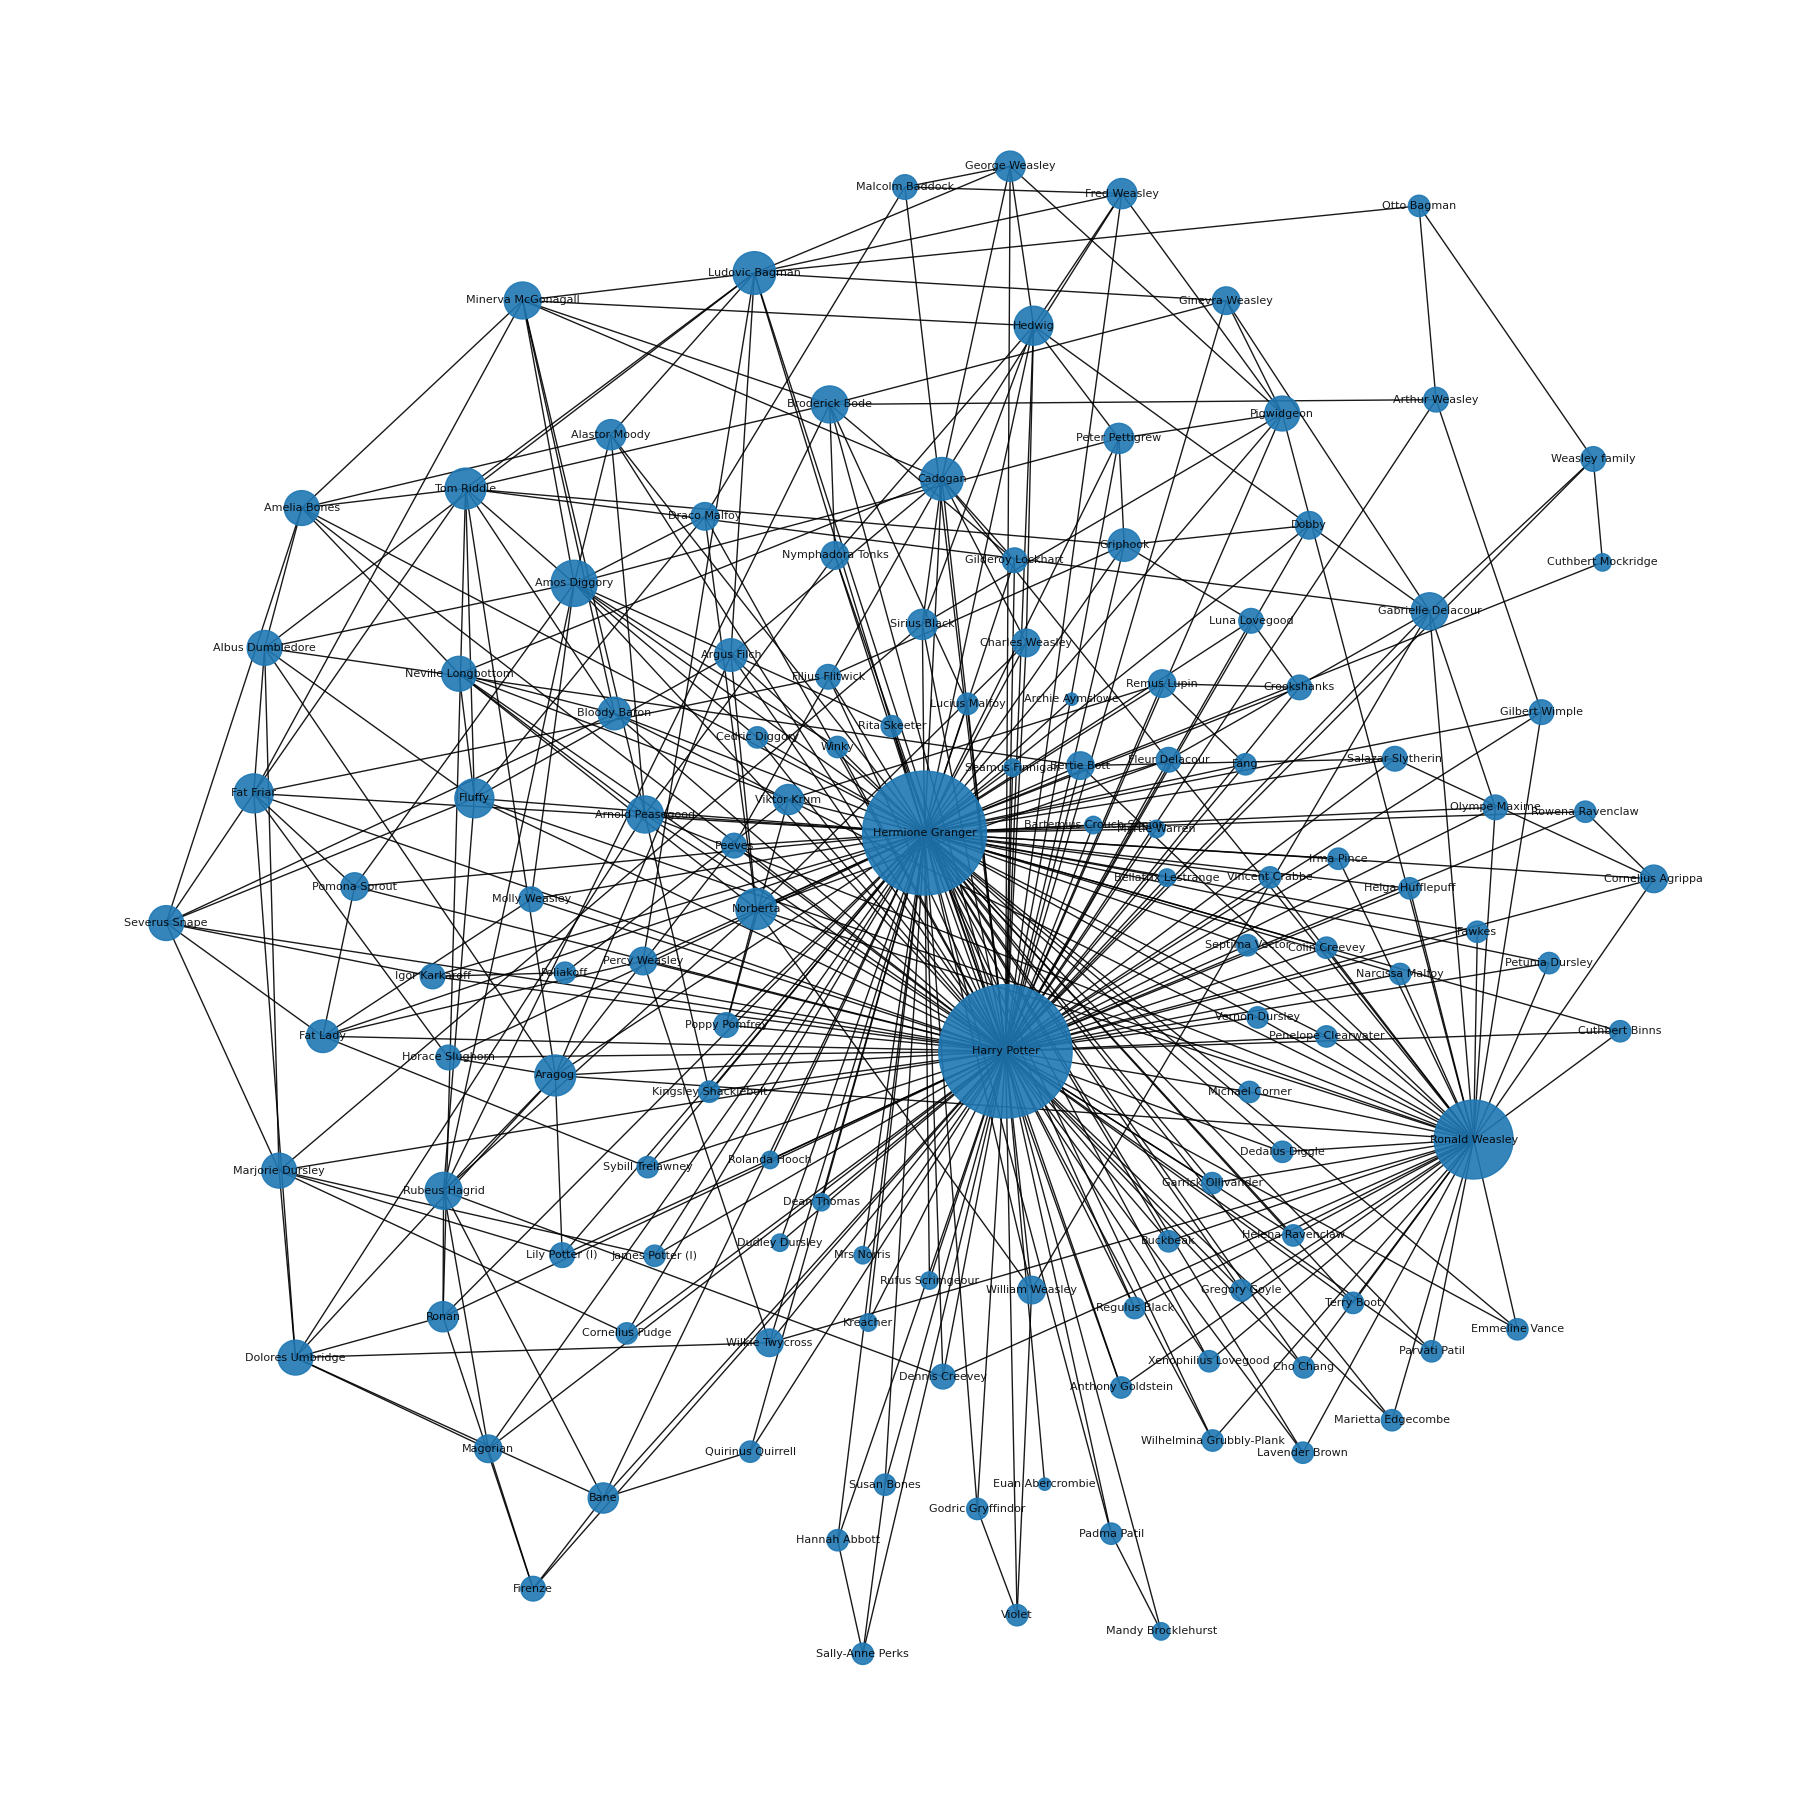

In [16]:
degree_b1 = nx.degree_centrality(b_filtered1_cc)
plt.figure(figsize=(18, 18))
pos = nx.forceatlas2_layout(
    b_filtered1,
    scaling_ratio=1,
    gravity=25, # Applies center of gravity
    max_iter=700
)

sizes_b1 = [v * 10000 for v in degree_b1.values()]  

# Draw graph
nx.draw(
    b_filtered1_cc,
    pos=pos,
    with_labels=True,
    node_size=sizes_b1,
    alpha=0.9,
    font_size=8
)
plt.show()

## Dispersion Analysis

In [1]:
from nltk import Text
import pickle
import os
import pickle
from nltk.tokenize import RegexpTokenizer

In [2]:
with open("Harry_potter_tokens\hp1_tokens.pkl", "rb") as f:
    tokens_dict = pickle.load(f)

In [2]:

def load_hp_tokens(folder_path):
    """
    Loads all pickle files in a folder containing token dictionaries.
    Each pickle is expected to contain: {chapter_name: [tokens]}
    Returns one flattened & cleaned token list.
    """

    all_tokens = []

    # NLTK tokenizer that keeps only alphabetic words
    tokenizer = RegexpTokenizer(r'[A-Za-z]+')

    # Loop through all pickle files
    for filename in os.listdir(folder_path):
        if filename.endswith(".pkl"):
            file_path = os.path.join(folder_path, filename)

            with open(file_path, "rb") as f:
                chapter_dict = pickle.load(f)

            # Merge all chapter token lists
            for token_list in chapter_dict.values():
                all_tokens.extend(token_list)

    # Clean with NLTK tokenizer
    cleaned_tokens = tokenizer.tokenize(" ".join(all_tokens))
    # We need to convert all tokens to small caps
    cleaned_tokens = [tok.lower() for tok in cleaned_tokens]

    return cleaned_tokens


In [5]:
cleaned_tokens = load_hp_tokens("Harry_potter_tokens")
print(len(cleaned_tokens))
print(cleaned_tokens[:50])


1167034
['one', 'the', 'boy', 'who', 'lived', 'mr', 'and', 'mrs', 'dursley', 'of', 'number', 'four', 'privet', 'drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'they', 'were', 'the', 'last', 'people', 'you', 'd', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because', 'they', 'just', 'didn', 't', 'hold', 'with']


In [3]:
all_tokens = []

for chapter, token_list in tokens_dict.items():
    all_tokens.extend(token_list)


In [ ]:
import re

clean_tokens = []
for tok in all_tokens:
    cleaned = re.sub(r'[^a-zA-Z]', '', tok)  # remove everything except letters
    if cleaned:  # avoid empty strings
        clean_tokens.append(cleaned)

In [27]:
# We need to convert all tokens to small caps
clean_tokens = [tok.lower() for tok in clean_tokens]

In [28]:
print(clean_tokens[:20])  # Print first 20 tokens to verify

['one', 'the', 'boy', 'who', 'lived', 'mr', 'and', 'mrs', 'dursley', 'of', 'number', 'four', 'privet', 'drive', 'were', 'proud', 'to', 'say', 'that', 'they']


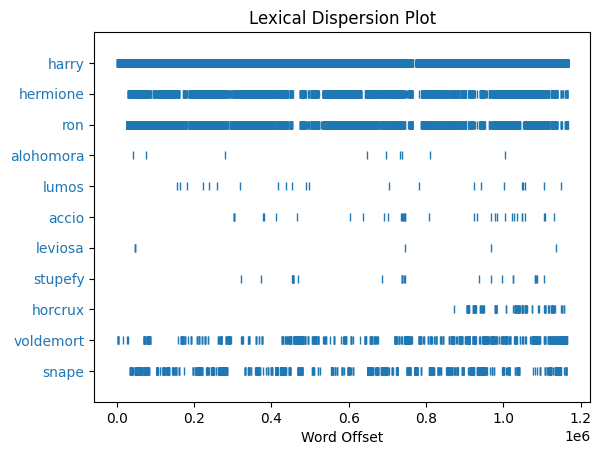

In [12]:

text = Text(cleaned_tokens)

text.dispersion_plot(['harry', 'hermione', 'ron', 'alohomora', 'lumos', 'accio', 'leviosa','stupefy', 'horcrux','voldemort', 'snape'])


In [ ]:
#display the first concordance match for 'hermione'
text.concordance('hermione')

Displaying 25 of 266 matches:
 i just hope it will be enough i m hermione granger by the way who are you she
ter said harry are you really said hermione i know all about you of course i g
wasn t neville the toadless boy or hermione granger this time three boys enter
d footsteps because a second later hermione granger had come in what has been 
over to the dark side he turned to hermione can we help you with something you
ing up and down the corridors said hermione in a sniffy voice and you ve got d
wed into their boat by neville and hermione everyone in shouted hagrid who had
too no one was talking much except hermione granger who was whispering very fa
ceiling dotted with stars he heard hermione whisper it s bewitched to look lik
 declared him a gryffindor granger hermione hermione almost ran to the stool a
 him a gryffindor granger hermione hermione almost ran to the stool and jammed
rry s other side percy weasley and hermione were talking about lessons i do ho
edle by the end of the

In [14]:
text.similar('Harry')
#text.common_contexts(['lord', 'earth'])

he it ron hagrid hermione they snape dudley him malfoy that you
dumbledore she there neville and what them all


## Who is the most active wizard ?

## Who is the most moody(negative) character ? 

## Who are the most central characters according to frequency and network ?

# Emma 

## **Louvain community detection.**

In [25]:
# Imports
import pickle, glob, re
import numpy as np
import os, re, glob, spacy
import pandas as pd
import networkx as nx
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community.quality import modularity

# Load metadata
with open("hp_character_metadata.pkl", "rb") as f:
    df_meta = pickle.load(f)      # columns: name, blood, species, gender, house, ...

# Load graph
G = nx.read_gexf("harry_potter_characters_network.gexf")
G_und = nx.Graph(G)               # Louvain requires undirected

character_names = list(G.nodes())

# Load tokens
files = sorted(glob.glob("Harry_potter_tokens/hp*_tokens.pkl"))
chapters = []
for fpath in files:
    with open(fpath, "rb") as handle:
        data = pickle.load(handle)   # dict: chapter -> tokens
        for chap, tokens in data.items():
            chapters.append(tokens)


In [3]:
def clean_chapter_text(tokens):
    txt = " ".join(tokens)
    txt = re.sub(r"[^A-Za-z0-9 ]+", " ", txt).lower()
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

char_text = defaultdict(list)

for tokens in chapters:
    txt = clean_chapter_text(tokens)

    for name in character_names:
        name_low = name.lower()
        last = name.split()[-1].lower()

        if name_low in txt or last in txt:
            char_text[name].append(txt)

df_chars = pd.DataFrame({
    "name": list(char_text.keys()),
    "clean_text": [" ".join(v) for v in char_text.values()]
})

df_chars["clean_text"] = df_chars["clean_text"].fillna("")


In [4]:
def clean_chapter_text(tokens):
    txt = " ".join(tokens)
    txt = re.sub(r"[^A-Za-z0-9 ]+", " ", txt).lower()
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

char_text = defaultdict(list)

for tokens in chapters:
    txt = clean_chapter_text(tokens)

    for name in character_names:
        name_low = name.lower()
        last = name.split()[-1].lower()

        if name_low in txt or last in txt:
            char_text[name].append(txt)

df_chars = pd.DataFrame({
    "name": list(char_text.keys()),
    "clean_text": [" ".join(v) for v in char_text.values()]
})

df_chars["clean_text"] = df_chars["clean_text"].fillna("")


In [5]:
df_full = df_meta.merge(df_chars, on="name", how="left")
df_full["clean_text"] = df_full["clean_text"].fillna("")
df_full.head()


name                     blood species  gender  \
0     Alastor Moody                Pure-blood   Human    Male   
1        Tom Riddle                Half-blood   Human    Male   
2  Albus Dumbledore                Half-blood   Human    Male   
3      Amelia Bones  Pure-blood or half-blood    None  Female   
4  Arnold Peasegood                      None   Human    Male   

               house            nationality  \
0            Unknown                          
1          Slytherin        England|English   
2         Gryffindor        England|English   
3      *Bones family  Great Britain|British   
4  *Peasegood family                   None   

                                                born  \
0                                        Before 1959   
1  31 December 1926 Wool's Orphanage, London, Eng...   
2  Between 16 August|16 and 31 August 1881 Mould-...   
3                                        Before 1973   
4                                    1976 or earlier   

                                                died  \
0                    27 July 1997 (aged at least 38)   
1  2 May 1998 (aged 71) Great Hall, Hogwarts Cast...   
2  30 June 1997 (aged 115) Astronomy Tower, Hogwa...   
3                    Between 28 June and 4 July 1996   
4                                                      

                                               alias  \
0                                      Mad-Eye Moody   
1  *Lord Voldemort (self-proclaimed title and cho...   
2                                           *Prefect   
3                                             *Madam   
4                                              Arnie   

                                       loyalty  \
0  *Hogwarts School of Witchcraft and Wizardry   
1                   *House of Gaunt (formerly)   
2                           *Dumbledore family   
3                                         None   
4                                         None   

                                                 job  \
0                                              Auror   
1              Purchasing agent at Borgin and Burkes   
2  *Professor of Defence Against the Dark Arts at...   
3                                               None   
4                                               None   

                                          clean_text  
0  thirteen the very secret diary hermione remain...  
1  ten the rogue bludger since the disastrous epi...  
2  one the boy who lived mr and mrs dursley of nu...  
3  four the keeper of the keys boom they knocked ...  
4  7 bagman and crouch harry disentangled himself...

In [6]:
# Louvain communities (Undirected Graph)
communities_louvain = louvain_communities(G_und, seed=42)
mod_louvain = modularity(G_und, communities_louvain)

print(f"Number of Louvain communities: {len(communities_louvain)}")
print(f"Modularity (Louvain):         {mod_louvain:.4f}")


Number of Louvain communities: 5
Modularity (Louvain):         0.1372


### Interpretation of Louvain Community Detection

The Louvain algorithm split the character co-occurrence network into **5 structural clusters**.  
To evaluate how meaningful these clusters are, we use the **modularity score**, which measures how well a network divides into separate communities.

#### Modularity Scale
- **0.0** → no community structure (random)
- **0.3–0.7** → strong communities
- **> 0.7** → extremely strong (rare in real datasets)

#### Result: Modularity = 0.1372
This value indicates:
- There is some community structure,  
- but the network is not strongly modular.

#### Why the modularity is low (and expected)
- Many characters appear across multiple books, mixing clusters.  
- The trio (Harry, Ron, Hermione) forms links between nearly all groups.  
- Harry interacts with all major factions, increasing cross-group edges.  
- The network is relatively small (52 nodes), which naturally reduces modularity.

In [32]:
node_to_comm = {}
for i, comm in enumerate(communities_louvain):
    for node in comm:
        node_to_comm[node] = i

df_full["community"] = df_full["name"].map(node_to_comm)
df_full[["name", "community"]].head()



name  community
0     Alastor Moody          1
1        Tom Riddle          3
2  Albus Dumbledore          4
3      Amelia Bones          0
4  Arnold Peasegood          0

### Mapping Characters to Louvain Communities
Tabel show mapping of character to the Louvain community they belong to and adds the community ID to the dataframe.
The output shows the first characters along with their assigned community numbers.

Community × House


house         *Albus Dumbledore  *Binns family  *Bones family  \
community                                                       
0          0                  0              0              1   
1          0                  1              0              0   
2          0                  0              0              0   
3          0                  0              0              0   
4          2                  0              1              0   

house      *British Ministry of Magic  *Crouch family  \
community                                               
0                                   2               1   
1                                   0               1   
2                                   0               0   
3                                   1               0   
4                                   0               0   

house      *Death Eaters (formerly)  *Delacour family  *Diggory family  \
community                                                                
0                                 0                 1                1   
1                                 0                 1                0   
2                                 0                 0                0   
3                                 1                 0                0   
4                                 0                 0                0   

house      *Dursley family  ...  Gringotts Wizarding Bank  Gryffindor  \
community                   ...                                         
0                        2  ...                         0           4   
1                        0  ...                         0           4   
2                        0  ...                         0           5   
3                        0  ...                         1           0   
4                        0  ...                         0           5   

house      Gryffindor, Hufflepuff, or Slytherin  \
community                                         
0                                             0   
1                                             0   
2                                             1   
3                                             0   
4                                             0   

house      Hogwarts School of Witchcraft and Wizardry  Hufflepuff  Ravenclaw  \
community                                                                      
0                                                   0           0          1   
1                                                   0           1          3   
2                                                   0           3          2   
3                                                   0           0          0   
4                                                   1           2          4   

house      Slytherin  Unknown  |loyalty=*British Ministry of Magic  \
community                                                            
0                  0        0                                    1   
1                  1        1                                    0   
2                  1        0                                    0   
3                  2        0                                    0   
4                  2        0                                    0   

house      |loyalty=Hogwarts School of Witchcraft and Wizardry  
community                                                       
0                                                          0    
1                                                          0    
2                                                          0    
3                                                          0    
4                                                          1    

[5 rows x 35 columns]

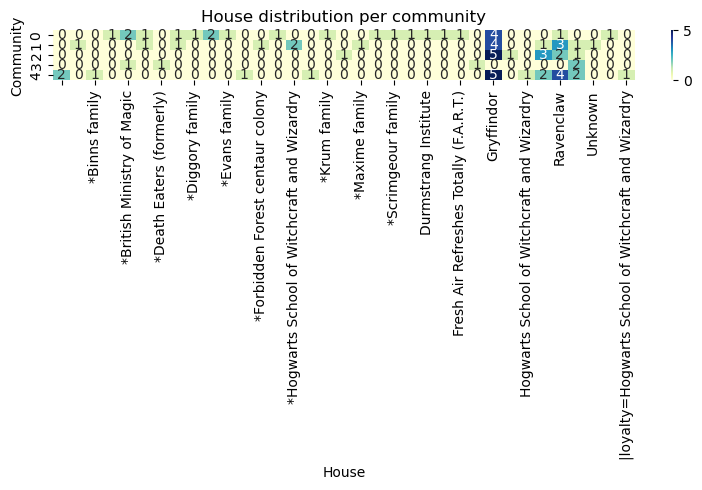

Community × Blood


blood         Half-blood  Muggle-born  Non-magic people|Muggle  Pure-blood  \
community                                                                    
0          4           1            0                        1           0   
1          4           2            1                        0           3   
2          1           0            1                        0           2   
3          2           1            0                        0           3   
4          6           3            1                        0           0   

blood      Pure-blood (possibly)  Pure-blood or half-blood  \
community                                                    
0                              0                         2   
1                              0                         2   
2                              1                         0   
3                              0                         0   
4                              0                         3   

blood      Pure-blood or half-blood (likely)  \
community                                      
0                                          1   
1                                          0   
2                                          0   
3                                          0   
4                                          1   

blood      Pure-blood or half-blood (most likely)  \
community                                           
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               1   

blood      Pure-blood or half-blood (possibly)  |alias=Vi  
community                                                  
0                                            1          0  
1                                            0          0  
2                                            0          0  
3                                            0          0  
4                                            0          1

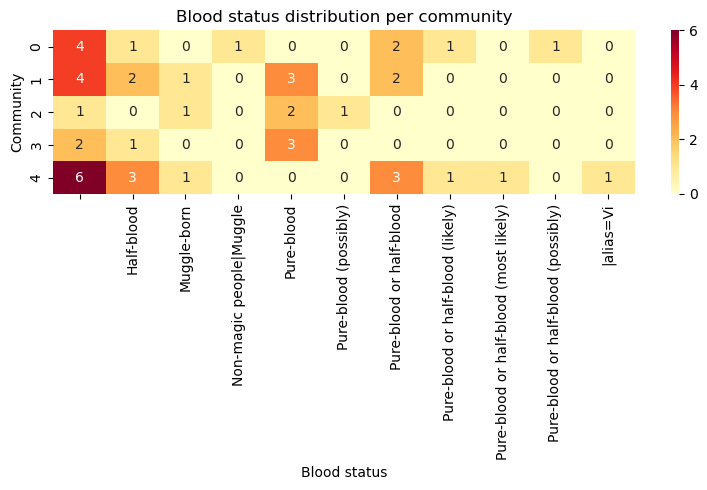

Community × Species


species    *Human  Centaur  Human  Part-human|Half-human/half-giant  \
community                                                             
0               0        3     14                                 1   
1               0        0     11                                 0   
2               0        0     18                                 0   
3               1        0      3                                 0   
4               1        0      6                                 0   

species    Poltergeist  
community               
0                    0  
1                    1  
2                    0  
3                    0  
4                    0

In [8]:
# Community × House
ct_house = pd.crosstab(df_full["community"], df_full["house"])
print("Community × House")
display(ct_house)

plt.figure(figsize=(8,5))
sns.heatmap(ct_house, annot=True, fmt="d", cmap="YlGnBu")
plt.title("House distribution per community")
plt.ylabel("Community")
plt.xlabel("House")
plt.tight_layout()
plt.show()

# Community × Blood status
ct_blood = pd.crosstab(df_full["community"], df_full["blood"])
print("Community × Blood")
display(ct_blood)

plt.figure(figsize=(8,5))
sns.heatmap(ct_blood, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Blood status distribution per community")
plt.ylabel("Community")
plt.xlabel("Blood status")
plt.tight_layout()
plt.show()

# Community × Species
ct_species = pd.crosstab(df_full["community"], df_full["species"])
print("Community × Species")
display(ct_species)


### Community × House, Blood, and Species Distributions

To understand whether the Louvain communities reflect narrative–world characteristics from the Harry Potter universe, following is researched. 

1. **Community × House**  
2. **Community × Blood status**  
3. **Community × Species**


---

#### 1. Community × House  
This table and heatmap show how Hogwarts houses (and family affiliations) are distributed across communities.  
Clear concentrations (e.g., many Gryffindors in the same community) indicate that the Louvain clusters capture real narrative structure.
Overall, the heatmap shows that several communities have strong concentrations in Gryffindor or Ravenclaw, which confirms that the Louvain clusters map onto real narrative or institutional groupings from the books.


---

#### 2. Community × Blood Status  
This distribution reveals whether communities group characters by magical blood purity.  
For example, some clusters contain mostly pure-blood characters while others mix half-blood and Muggle-born individuals, indicating different social groupings within the story.
The heatmap makes it clear that some communities (especially 3 and 4) are dominated by pure-blood characters, matching known social structures within the story (e.g., Ministry, Dumbledore family, traditional wizard families).

---

#### 3. Community × Species  
This crosstab counts humans, centaurs, part-humans, and other species within each community.  
Most communities are dominated by humans, but the presence of centaurs or other species helps identify communities connected to specific environments or subplots.
Across all communities, humans dominate, but the presence of centaurs, half-giants, or poltergeists helps identify communities connected to specific subplots (e.g., Forbidden Forest or Hogwarts ghosts).


---
### Summary

The three heatmaps—House, Blood Status, and Species—validate that the Louvain communities are not random.  
They reflect meaningful narrative structures:  
- student groups (Communities 1 and 2),  
- pure-blood or elite wizard clusters (Communities 3 and 4),  
- and mixed or creature-connected groups (Community 0).  
Together, these analyses show that the network clustering captures underlying social and institutional divisions within the Harry Potter universe.

In [9]:
# Graph 

import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
import numpy as np

# ---- 1) Beregn layout (samme som før, men pænere) ----
pos = nx.spring_layout(G_und, seed=42, k=0.5)   # stabilt layout

# ---- 2) Farver per community ----
num_comms = len(communities_louvain)
colors = px.colors.qualitative.Set2[:num_comms]  # fine farver

# Map node → community
node_to_comm = {}
for i, comm in enumerate(communities_louvain):
    for node in comm:
        node_to_comm[node] = i

# ---- 3) Lav edge-traces ----
edge_x = []
edge_y = []

for u,v in G_und.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color="rgba(150,150,150,0.3)"),
    hoverinfo='none',
    mode='lines'
)

# ---- 4) Node traces per community ----
node_traces = []

for c in range(num_comms):
    xs, ys, text = [], [], []
    
    for node in communities_louvain[c]:
        x, y = pos[node]
        xs.append(x)
        ys.append(y)
        text.append(node)  # hover label
        
    trace = go.Scatter(
        x=xs, y=ys,
        mode="markers",
        marker=dict(
            size=14,
            color=colors[c],
            line=dict(width=1, color="black")
        ),
        text=text,
        name=f"Community {c}",
        hovertemplate="<b>%{text}</b><extra></extra>"
    )
    node_traces.append(trace)

# ---- 5) Plotly figur ----
fig = go.Figure()

fig.add_trace(edge_trace)
for tr in node_traces:
    fig.add_trace(tr)

fig.update_layout(
    title="Louvain Communities (Interactive Plotly Graph)",
    title_x=0.5,
    showlegend=True,
    width=1200,
    height=800,
    plot_bgcolor="white",
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=False)
)

fig.show()


### Louvain Communities – Interactive Graph Interpretation

The interactive Plotly graph visualizes the full character co-occurrence network with nodes colored by their Louvain community.  
Each node represents a character, edges represent how often two characters appear together.

#### What the plot shows:

- **Five distinct colored groups** correspond to the five Louvain communities detected earlier.
- The graph is very dense in the center, reflecting how strongly connected the main cast is across the books.
- **Rubeus Hagrid** (hovered in the screenshot) sits near the center because he interacts with characters across several communities (students, staff, creatures), making him a structural bridge.
- Characters positioned closer together tend to co-occur frequently in the text, forming narrative clusters such as:
  - **Gryffindor core** (Harry, Ron, Hermione)  
  - **Death Eaters / antagonists**  
  - **Hogwarts staff**  
  - **Secondary student groups**  
- The outer ring of nodes contains characters with fewer connections, who appear in more isolated episodes or specific subplots.

#### Why the visualization is useful:
- It gives a global overview of the story’s social structure.
- The color-coded communities visually confirm the numeric results from the Louvain algorithm.
- Dense clusters highlight tightly connected groups, while peripheral nodes represent characters with limited narrative overlap.
- Hovering allows detailed inspection of individual characters and their positions within the network.


In [10]:
ct_loyalty = pd.crosstab(df_full["community"], df_full["loyalty"])
display(ct_loyalty)


loyalty    *Abbott family  *Bones family  *Boot family  *Brocklehurst family  \
community                                                                      
0                       0              0             0                     1   
1                       0              0             0                     0   
2                       1              1             1                     0   
3                       0              0             0                     0   
4                       0              0             0                     0   

loyalty    *Brown family  *Chang family  *Clearwater family  *Corner family  \
community                                                                     
0                      0              0                   0               0   
1                      0              0                   0               0   
2                      1              1                   0               1   
3                      0              0                   1               0   
4                      0              0                   0               0   

loyalty    *Crabbe family  *Creevey family  ...  *Slughorn family  \
community                                   ...                     
0                       0                0  ...                 0   
1                       0                0  ...                 1   
2                       0                2  ...                 0   
3                       1                0  ...                 0   
4                       0                0  ...                 0   

loyalty    *Slytherin family  *Snape family  *Sprout family  *Thomas family  \
community                                                                     
0                          0              0               0               0   
1                          0              0               0               0   
2                          0              0               0               1   
3                          0              0               0               0   
4                          1              1               1               0   

loyalty    *Tonks family  *Trelawney family  *Vance family  *Warren family  \
community                                                                    
0                      0                  0              0               0   
1                      1                  1              1               0   
2                      0                  0              0               0   
3                      0                  0              0               0   
4                      0                  0              0               1   

loyalty    *Weasley family  
community                   
0                        1  
1                        3  
2                        4  
3                        0  
4                        0  

[5 rows x 51 columns]

In [11]:
def purity(table):
    pure = table.max(axis=1).sum()
    total = table.sum().sum()
    return pure / total

print("House purity:", purity(ct_house))
print("Blood purity:", purity(ct_blood))
print("Species purity:", purity(ct_species))
print("Loyalty purity:", purity(ct_loyalty))


House purity: 0.2564102564102564
Blood purity: 0.3877551020408163
Species purity: 0.8813559322033898
Loyalty purity: 0.23684210526315788


### Community × Loyalty

The `Community × Loyalty` crosstab shows how members of different Hogwarts-related families or loyalty groups are distributed across the five Louvain communities.  
Each row corresponds to a community, and each column represents a family/loyalty group (e.g., *Weasley family*, *Snape family*, *Bones family*, *Creevey family*, etc.).

#### What the loyalty table shows:
- **Community 0** contains almost no strong loyalty clusters, except a single *Weasley family* member.
- **Community 1** shows loyalty diversity with members of the *Slughorn*, *Tonks*, *Trelawney*, and *Weasley* families, indicating a mixed Hogwarts-affiliated group.
- **Community 2** has the highest loyalty concentration, especially in the *Creevey family* (2) and *Weasley family* (4), suggesting this community captures a large portion of student/family-based characters.
- **Community 3** shows minimal loyalty presence and appears more fragmented.
- **Community 4** contains loyalty ties to the *Slytherin*, *Snape*, *Sprout*, and *Warren* families, showing a cluster with more staff or specialized affiliations.

Overall, the distribution shows that some communities contain clearly identifiable loyalty clusters (especially Community 2), while others are more mixed.

---

### Purity Scores

The `purity()` function measures how well each attribute (house, blood status, species, loyalty) aligns with the Louvain communities.

- For each community, the function finds the largest group inside that community (e.g., most common house or blood type).
- It sums these “dominant” counts across all communities.
- Then it divides by the total number of characters.

This yields a value between 0 and 1, where:
- **1.0** means each community contains characters from only one category (perfect separation).
- **0.0** means categories are fully mixed across communities (no structure).

#### Purity results:
- **House purity:** 0.256  
  → House affiliation is spread across communities; not a strong driver of the clustering.
- **Blood purity:** 0.388  
  → Blood status matches community structure better than houses, but still moderately.
- **Species purity:** 0.881  
  → Species is highly aligned with the communities; nearly all communities contain mostly one species (human).
- **Loyalty purity:** 0.237  
  → Loyalty is highly mixed across communities, indicating weak separation by family or allegiance.

#### Interpretation:
Louvain communities are not strongly defined by House or Loyalty, moderately shaped by Blood status, and very strongly shaped by Species (mostly because almost all characters are human).  
This suggests that the Louvain algorithm groups characters primarily based on shared narrative contexts and co-occurrence, not simple metadata attributes.


In [12]:

def dominant_attribute(ct_table, label):
    """
    Finder den dominerende attribut pr. community for en given crosstab.
    """
    dom = ct_table.idxmax(axis=1)          # hvilken kolonne (attribut) har det højeste tal?
    counts = ct_table.max(axis=1)          # hvor mange har denne attribut?
    total = ct_table.sum(axis=1)           # community-størrelse
    purity = counts / total                # hvor ren er den?
    
    return pd.DataFrame({
        "Dominant " + label: dom,
        "Count": counts,
        "Total": total,
        "Purity": purity.round(3)
    })

# ---- Lav tabeller for alle fire områder ----
table_house   = dominant_attribute(ct_house, "House")
table_blood   = dominant_attribute(ct_blood, "Blood")
table_species = dominant_attribute(ct_species, "Species")
table_loyalty = dominant_attribute(ct_loyalty, "Loyalty")

# ---- Combine i én stor tabel ----
summary = pd.concat(
    [table_house, table_blood, table_species, table_loyalty],
    axis=1
)

summary


Dominant House  Count  Total  Purity Dominant Blood  Count  Total  \
community                                                                     
0             Gryffindor      4     23   0.174                     4     10   
1             Gryffindor      4     17   0.235                     4     12   
2             Gryffindor      5     13   0.385     Pure-blood      2      5   
3              Slytherin      2      5   0.400     Pure-blood      3      6   
4             Gryffindor      5     20   0.250                     6     16   

           Purity Dominant Species  Count  Total  Purity  \
community                                                  
0           0.400            Human     14     18   0.778   
1           0.333            Human     11     12   0.917   
2           0.400            Human     18     18   1.000   
3           0.500            Human      3      4   0.750   
4           0.375            Human      6      7   0.857   

                                      Dominant Loyalty  Count  Total  Purity  
community                                                                     
0                     *Forbidden Forest centaur colony      3     10   0.300  
1                                      *Weasley family      3     19   0.158  
2                                      *Weasley family      4     22   0.182  
3                                      *House of Black      3      9   0.333  
4          *Hogwarts School of Witchcraft and Wizardry      5     16   0.312

### Dominant Attribute Summary per Community

The summary table combines information from four crosstabs (House, Blood status, Species, and Loyalty) and identifies, for each community, which attribute category appears most frequently.  
For each attribute the table shows:

- **Dominant category** (e.g., Gryffindor, Pure-blood, Human, Weasley family)  
- **Count:** how many characters in the community have that category  
- **Total:** total characters in the community  
- **Purity:** Count / Total — how strongly the dominant category represents the community

#### Interpretation of each community:

---

### **Community 0**
- **Dominant House:** Gryffindor (4 of 23 → purity 0.174)  
- **Dominant Blood:** Half-blood (4 of 10 → 0.400)  
- **Dominant Species:** Human (14 of 18 → 0.778)  
- **Dominant Loyalty:** *Forbidden Forest centaur colony (3 of 10 → 0.300)*  
→ Community 0 is loosely structured, with weak house/blood purity but strong species purity.

---

### **Community 1**
- **Dominant House:** Gryffindor (4 of 17 → 0.235)  
- **Dominant Blood:** Half-blood (4 of 12 → 0.333)  
- **Dominant Species:** Human (11 of 12 → 0.917)  
- **Dominant Loyalty:** *Weasley family* (3 of 19 → 0.158)  
→ A mixed Hogwarts student/staff group with high species purity but very low loyalty purity.

---

### **Community 2**
- **Dominant House:** Gryffindor (5 of 13 → 0.385)  
- **Dominant Blood:** Pure-blood (2 of 5 → 0.400)  
- **Dominant Species:** Human (18 of 18 → **1.000**)  
- **Dominant Loyalty:** *Weasley family* (4 of 22 → 0.182)  
→ Community 2 shows the highest species purity of any group (purely human) and contains many Gryffindor-linked characters.

---

### **Community 3**
- **Dominant House:** Slytherin (2 of 5 → 0.400)  
- **Dominant Blood:** Pure-blood (3 of 6 → 0.500)  
- **Dominant Species:** Human (3 of 4 → 0.750)  
- **Dominant Loyalty:** *House of Black* (3 of 9 → 0.333)  
→ Community 3 resembles a darker or more traditional-wizard cluster, with Slytherin and pure-blood dominance.

---

### **Community 4**
- **Dominant House:** Gryffindor (5 of 20 → 0.250)  
- **Dominant Blood:** Half-blood (6 of 16 → 0.375)  
- **Dominant Species:** Human (6 of 7 → 0.857)  
- **Dominant Loyalty:** *Hogwarts School of Witchcraft and Wizardry* (5 of 16 → 0.312)  
→ Community 4 is a staff/authority cluster with strong Hogwarts-affiliation signals and high species purity.

---

### **Overall Conclusion**

- Species shows the strongest purity across communities — meaning communities are almost entirely human with very few magical creatures.  
- Blood status** shows moderate purity — some communities align with pure-blood groups (especially Community 3).  
- House and Loyalty show low purity, meaning the Louvain clusters do not strongly separate characters based on Hogwarts house or family loyalties.  
- The summary confirms that Louvain communities are driven more by co-occurrence patterns in the story than by simple metadata categories.


# Harry Pooter Books TF-IDF


In [22]:
# Load book text 
import os, glob

# If your notebook is directly inside the project folder:
BOOK_DIR = "./txt"

txt_files = sorted(glob.glob(os.path.join(BOOK_DIR, "*.txt")))
print("Books loaded:", txt_files)

books_raw = {}
for path in txt_files:
    book_id = os.path.basename(path).replace(".txt", "")
    with open(path, "r", encoding="utf8", errors="ignore") as f:
        books_raw[book_id] = f.read()

print("Total books:", len(books_raw))


Books loaded: ["./txt/HP1 - Harry Potter and the Sorcerer's Stone.txt", './txt/HP2 - Harry Potter and the Chamber of Secrets.txt', './txt/HP3 - Harry Potter and the Prisoner of Azkaban.txt', './txt/HP4 - Harry Potter and the Goblet of Fire.txt', './txt/HP5 - Harry Potter and the Order of the Phoenix.txt', './txt/HP6 - Harry Potter and the Half-Blood Prince.txt', './txt/HP7 - Harry Potter and the Deathly Hallows.txt', './txt/HP8 - Harry Potter and the Cursed Child.txt']
Total books: 8


In [23]:
# NLP PREPROCESSING
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2_000_000

def preprocess(text):
    doc = nlp(text.lower())
    tokens = []
    for t in doc:
        if t.is_alpha and len(t.lemma_) >= 4 and not t.is_stop:
            tokens.append(t.lemma_)
    return " ".join(tokens)

print("Preprocessing books (30–60 seconds)…")
books_clean = {bid: preprocess(txt) for bid, txt in books_raw.items()}


Preprocessing books (30–60 seconds)…


In [26]:
# HIGH-QUALITY TF-IDF

hp_stopwords = {
    "chapter","harry","potter","ron","hermione","dumbledore","snape","voldemort",
    "hagrid","mcgonagall","sirius","lupin","weasley","malfoy","hogwarts",
    "ministry","magic","wand","look","looked","said","asked",
    "could","would","also","still","even","however","gotten"
}

vectorizer = TfidfVectorizer(
    stop_words=list(hp_stopwords),
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2),
    lowercase=False
)

docs = [books_clean[b] for b in books_clean]
book_ids = list(books_clean.keys())
X = vectorizer.fit_transform(docs)
vocab = vectorizer.get_feature_names_out()

print("TF-IDF shape:", X.shape)

TF-IDF shape: (8, 43036)


In [27]:
#  TOP TF-IDF TERMS PER BOOK

def top_terms(i, k=25):
    row = X[i].toarray().ravel()
    idx = row.argsort()[::-1][:k]
    return [(vocab[j], row[j]) for j in idx]

for i, bid in enumerate(book_ids):
    print(f"\n=== {bid} ===")
    for w, s in top_terms(i, 20):
        print(f"{w:30s} {s:.4f}")


=== HP1 - Harry Potter and the Sorcerer's Stone ===
quirrell                       0.4421
flamel                         0.1859
filch                          0.1528
norbert                        0.1245
percy                          0.1075
nearly                         0.1019
ronan                          0.0917
twin                           0.0905
trapdoor                       0.0854
professor quirrell             0.0850
nicolas                        0.0797
unicorn                        0.0792
fluffy                         0.0764
ollivander                     0.0764
firenze                        0.0764
halloween                      0.0723
erise                          0.0691
turban                         0.0691
bane                           0.0643
pier                           0.0643

=== HP2 - Harry Potter and the Chamber of Secrets ===
lockhart                       0.5653
dobby                          0.3482
riddle                         0.2413
myrtle            

### Top TF-IDF Terms per Book — Interpretation

The TF-IDF scores highlight words that are *especially distinctive* for each book compared to the others.  
High-scoring terms represent characters, objects, creatures, and plot elements that are uniquely important in that specific installment of the series.

Below is a book-by-book interpretation of the dominant TF-IDF terms.

---

#### **HP1 – Sorcerer’s Stone**
Top terms: *quirrell, flamel, fluffy, norbert, unicorn, trapdoor, turban*

These terms reflect the major plotline of book 1:
- Professor Quirrell and his hidden intentions  
- Nicolas Flamel and the Philosopher’s Stone  
- Magical creatures like Fluffy, Norbert the dragon, and unicorns  
- The trapdoor guarding the Stone  

TF-IDF correctly isolates the core mystery and key magical elements of the first book.

---

#### **HP2 – Chamber of Secrets**
Top terms: *lockhart, dobby, riddle, myrtle, diary, basilisk, aragog*

These terms represent the central elements of the Chamber of Secrets:
- Gilderoy Lockhart's comedic presence  
- Dobby's warnings  
- Tom Riddle and the cursed diary  
- Moaning Myrtle’s bathroom and death  
- Basilisk attacks  
- Aragog and the spiders  

The model captures the central threat and major new characters introduced in HP2.

---

#### **HP3 – Prisoner of Azkaban**
Top terms: *dementor, pettigrew, scabbers, buckbeak, boggart, patronus*

These terms focus on:
- The Dementors and their role as antagonists  
- Peter Pettigrew / Scabbers  
- Buckbeak and the Hippogriff trial  
- Trelawney and Divination  
- Patronus magic  

TF-IDF isolates the themes of fear, identity, and time-turning that dominate this book.

---

#### **HP4 – Goblet of Fire**
Top terms: *moody, bagman, crouch, cedric, winky, krum, karkaroff, champion, task*

These terms correspond directly to:
- Triwizard Tournament champions (Cedric, Krum)  
- Tasks and challenges  
- Barty Crouch Sr. & Jr., Winky, Bagman  
- Fake Moody (Barty Crouch Jr.)  

TF-IDF captures the international tournament arc and the Crouch family deception central to HP4.

---

#### **HP5 – Order of the Phoenix**
Top terms: *umbridge, luna, kreacher, prophecy, centaur, grawp*

These terms reflect:
- Dolores Umbridge and her takeover of Hogwarts  
- Luna Lovegood’s prominent introduction  
- Kreacher’s role in the Order  
- The prophecy relating to Harry and Voldemort  
- Grawp and the centaurs  

The model identifies HP5 as the book of rebellion, the Ministry conflict, and mental tension.

---

#### **HP6 – Half-Blood Prince**
Top terms: *slughorn, riddle, horcrux, scrimgeour, minister, narcissa*

These words highlight:
- Professor Slughorn’s return and memory  
- Tom Riddle’s past  
- Horcrux knowledge  
- Minister Scrimgeour and political tension  

TF-IDF pinpoints the Horcrux exposition and Slughorn’s memory arc as the heart of HP6.

---

#### **HP7 – Deathly Hallows**
Top terms: *death eater, griphook, horcrux, sword, hallow, locket, greyback, fleur*

These terms emphasize:
- Death Eaters and the war  
- Griphook and the Gringotts break-in  
- Horcrux hunt (locket, sword)  
- Hallows mythology  
- Greyback the werewolf  

HP7’s TF-IDF results capture the Horcrux quest and dark war themes.

---

#### **HP8 – Cursed Child**
Top terms: *scorpius, albus, time turner, amos, cedric, myrtle*

These reflect:
- Scorpius Malfoy as the narrative focus  
- Albus Potter’s journey  
- Time-Turner plotline  
- Cedric’s alternate-timeline storyline  
- Myrtle’s recurring role  

TF-IDF isolates HP8’s emphasis on time travel, legacy characters, and father–son tension.

---

### Summary

Across all books, TF-IDF extracts:
- Major characters unique to each story  
- Plot-specific magical objects  
- Core threats and mysteries  
- Book-defining themes

This demonstrates that the textual model captures distinctive narrative signatures for each part of the Harry Potter series.


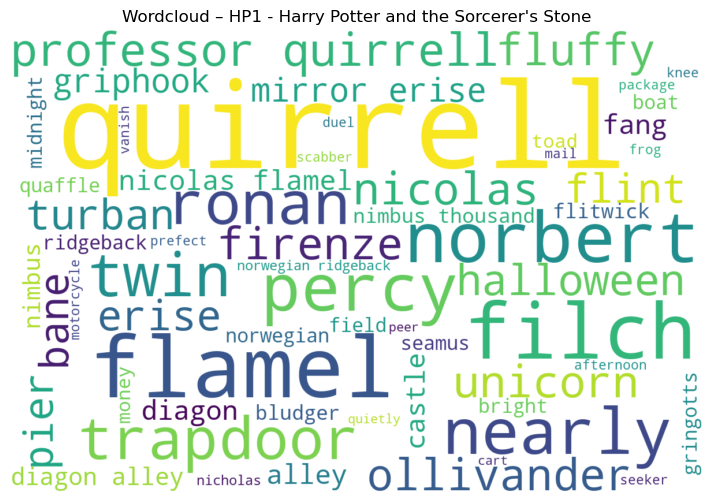

In [28]:
# WORDCLOUDS
def plot_wordcloud(i):
    freqs = dict(top_terms(i, 60))
    wc = WordCloud(width=1200, height=800, background_color="white")
    plt.figure(figsize=(10,6))
    plt.imshow(wc.generate_from_frequencies(freqs), interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Wordcloud – {book_ids[i]}")
    plt.show()

# Example:
plot_wordcloud(0)


**Word cloud** The HP1 wordcloud is dominated by “Quirrell” and “Flamel,” showing how the plot centers on the Philosopher’s Stone mystery.  
Creature terms like “fluffy,” “unicorn,” “firenze,” and “norbert” highlight the book’s focus on magical creatures and early-world discovery.  
Words such as “trapdoor,” “mirror,” and “erise” point to the Stone’s magical protections and the Mirror of Erised storyline.  
Names like “percy,” “filch,” and “flint” reflect the introduction of important Hogwarts side characters.  



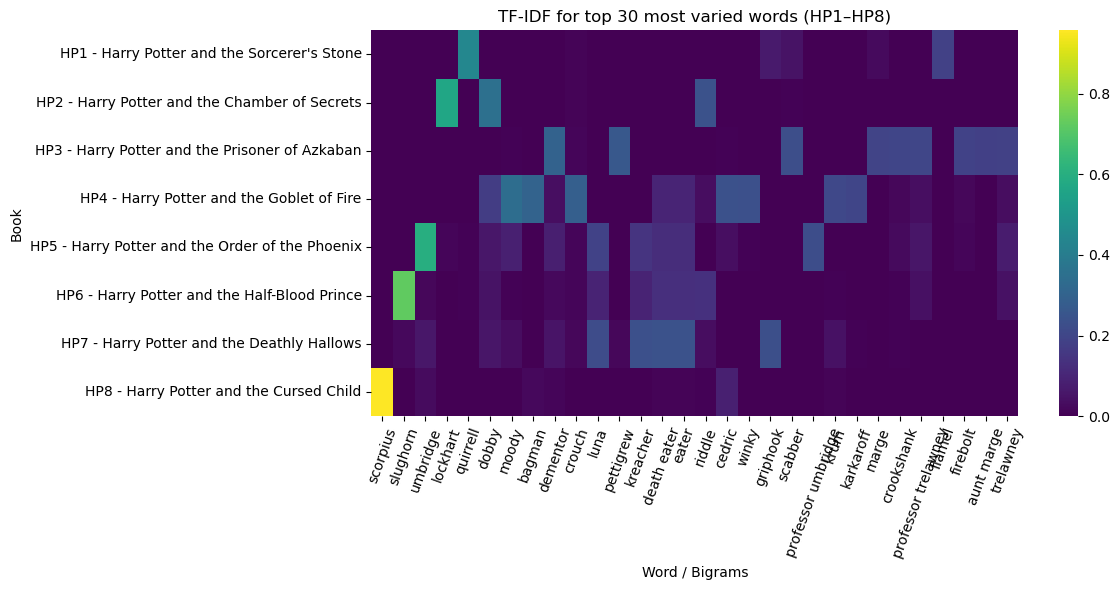


=== Highly Variable TF-IDF Words and Their Strongest Book ===
scorpius                       -> HP8 - Harry Potter and the Cursed Child  (score = 0.9570)
slughorn                       -> HP6 - Harry Potter and the Half-Blood Prince  (score = 0.7217)
umbridge                       -> HP5 - Harry Potter and the Order of the Phoenix  (score = 0.6015)
lockhart                       -> HP2 - Harry Potter and the Chamber of Secrets  (score = 0.5653)
quirrell                       -> HP1 - Harry Potter and the Sorcerer's Stone  (score = 0.4421)
dobby                          -> HP2 - Harry Potter and the Chamber of Secrets  (score = 0.3482)
moody                          -> HP4 - Harry Potter and the Goblet of Fire  (score = 0.3371)
bagman                         -> HP4 - Harry Potter and the Goblet of Fire  (score = 0.2992)
dementor                       -> HP3 - Harry Potter and the Prisoner of Azkaban  (score = 0.2957)
crouch                         -> HP4 - Harry Potter and the Goblet o

In [29]:
# vælg ord med højest varians på tværs af bøger
variances = X.toarray().var(axis=0)
top_var_idx = np.argsort(variances)[::-1][:30]

X_var = X[:, top_var_idx].toarray()
vocab_var = [vocab[i] for i in top_var_idx]

plt.figure(figsize=(12, 6))
sns.heatmap(
    X_var,
    xticklabels=vocab_var,
    yticklabels=book_ids,
    cmap="viridis"
)
plt.title("TF-IDF for top 30 most varied words (HP1–HP8)")
plt.xlabel("Word / Bigrams")
plt.ylabel("Book")
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()



print("\n=== Highly Variable TF-IDF Words and Their Strongest Book ===")
for idx in top_var_idx[:20]:   # show top 20 most varied words
    col = X[:, idx].toarray().ravel()
    best_i = col.argmax()
    print(f"{vocab[idx]:30s} -> {book_ids[best_i]}  (score = {col[best_i]:.4f})")



**1. TF–IDF Heatmap — Top 30 Most Varied Words Across Books**
This heatmap shows the 30 words with the highest TF–IDF variance across all books.  
Bright vertical bands indicate words that are strongly associated with one specific book.  
For example, “scorpius” appears only in HP8, “slughorn” peaks in HP6, and “umbridge” dominates HP5.  
The pattern demonstrates that each book has a unique lexical signature shaped by its characters and plot elements.  
Overall, the heatmap visualizes how distinct vocabulary highlights the narrative focus of each installment.


**Highly Variable Words — Strongest Book List**
This table lists the most variable TF–IDF words along with the book in which each word is strongest.  
It confirms that terms like “quirrell,” “lockhart,” “dobby,” “slughorn,” and “scorpius” are highly book-specific.  
These character and plot-related words serve as strong markers of each book’s thematic identity.  
Many words appear almost exclusively in a single book, giving them high discriminative power in TF–IDF.  



Computing cosine distance matrix (D-matrix)...


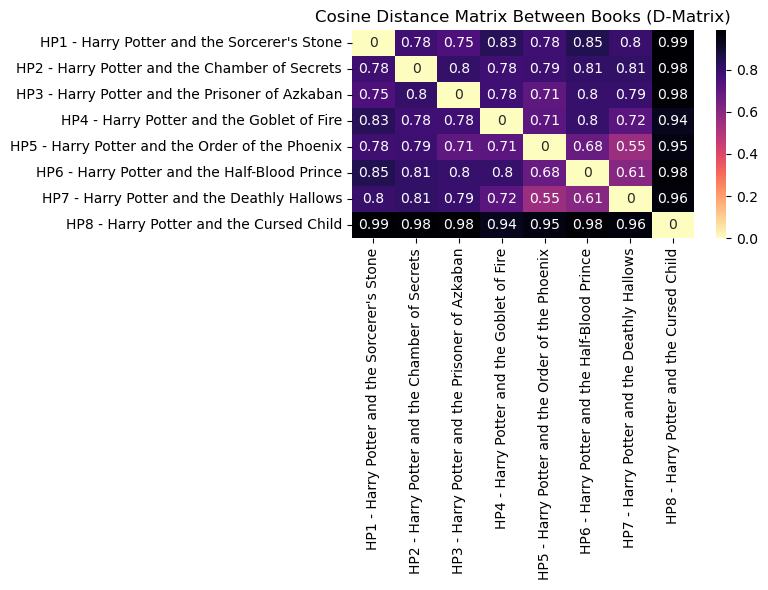

In [30]:
# D-MATRIX (cosine distances between books)
print("\nComputing cosine distance matrix (D-matrix)...")

D = cosine_distances(X)
df_D = pd.DataFrame(D, index=book_ids, columns=book_ids)

plt.figure(figsize=(8, 6))
sns.heatmap(df_D, annot=True, cmap="magma_r")
plt.title("Cosine Distance Matrix Between Books (D-Matrix)")
plt.tight_layout()
plt.show()

**Cosine Distance Matrix Between Books (D-Matrix)**
This matrix shows the cosine distance between books based on their TF–IDF vectors.  
Lower values indicate greater similarity in vocabulary usage, while higher values indicate larger differences.  
We see, for example, that HP5 and HP6 are more similar, whereas HP8 is highly different from all other books.  
HP1, HP2, and HP3 also form a tighter cluster, reflecting the early-school-year tone.  
Overall, the matrix reveals which books are linguistically close and where major stylistic or thematic shifts occur.
